In [1]:
import jax
import chex
import einops
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt

from io import StringIO
from functools import partial
from datetime import datetime

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 16
sns.set_palette("hls", 6)

In [3]:
theta_values = -2, -1, 0, 3, 7,

## HMM Orstein-Uhlenbeck process

$$
    x_{t+\Delta}^\ell = \kappa(\theta_{t, \ell} - x_{t, \ell}) \Delta + \sigma\sqrt{\Delta} W_t
$$

with $W_t \sim \cal{N}(0, 1)$

In [4]:
transition_matrix = jnp.array([
    [0.00,  0.05, 0.05, 0.05, 0.05],
    [0.10,  00.0, 0.10, 0.05, 0.05],
    [0.10,  0.20, 0.00, 0.05, 0.05],
    [0.10,  0.20, 0.01, 0.00, 0.05],
    [0.10,  0.20, 0.20, 0.20, 0.00],
])

p_stay = 1 - transition_matrix.sum(axis=1)
transition_matrix = transition_matrix.at[jnp.diag_indices(5)].set(p_stay)

transition_matrix

Array([[0.8       , 0.05      , 0.05      , 0.05      , 0.05      ],
       [0.1       , 0.7       , 0.1       , 0.05      , 0.05      ],
       [0.1       , 0.2       , 0.59999996, 0.05      , 0.05      ],
       [0.1       , 0.2       , 0.01      , 0.64      , 0.05      ],
       [0.1       , 0.2       , 0.2       , 0.2       , 0.3       ]],      dtype=float32)

## Loading datset

In [5]:
url = """
https://query1.finance.yahoo.com/v7/finance/download/TSLA?period1=345427200&period2=1701993600&interval=1d&events=history&includeAdjustedClose=true
"""

In [6]:
date_init = datetime.timestamp(datetime(2000, 1, 1))
date_end = datetime.timestamp(datetime(2023, 12, 8))

config = {
    "events": "history",
    "period1": str(int(date_init)),
    "period2": str(int(date_end)),
    "includeAdjustedClose": "true"
}

In [7]:
assets = ["JPM", "AAPL", "SHEL", "WMT", "KO", "HD"]

In [8]:
datasets = {}
for asset in assets:
    url = f"https://query1.finance.yahoo.com/v7/finance/download/{asset}"
    r = requests.get(
        url,
        headers={'User-agent': 'Mozilla/5.0'},
        params=config
    )

    data = pd.read_csv(StringIO(r.text))
    data["Date"] = pd.to_datetime(data["Date"])
    data = data.set_index("Date")

    series = data["Adj Close"]
    series.name = asset
    datasets[asset] = series
datasets = pd.DataFrame.from_dict(datasets)

In [9]:
returns = np.log1p(datasets.pct_change(1)).dropna() # log(1 + x); x = (S1 / S0 - 1); log(1 + S1 / S0 - 1) = log(S1 / S0)
returns = jnp.array(returns.to_numpy())
n_steps, _ = returns.shape
timesteps = np.arange(n_steps)

In [10]:
# returns = jnp.c_[returns, jnp.zeros(n_steps)]
# assets = [*assets, "NULL"]

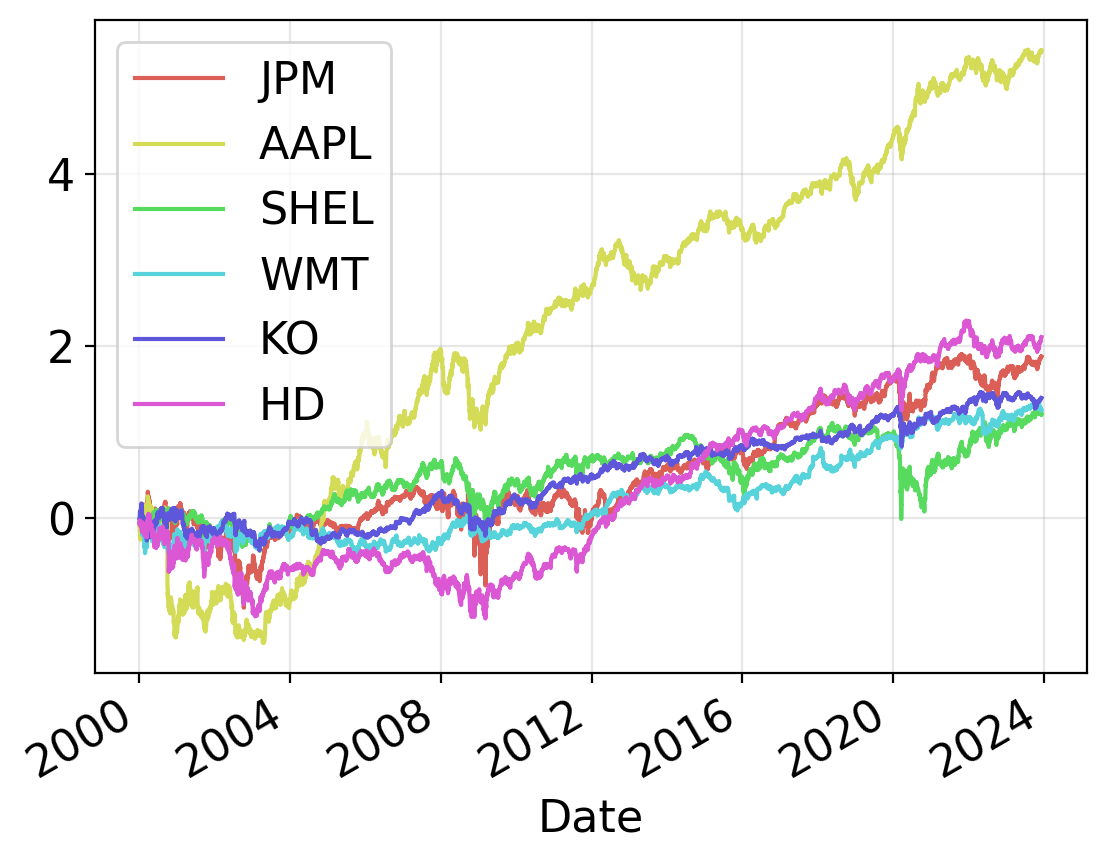

In [160]:
datasets_logr = pd.DataFrame(np.array(returns), index=datasets.index[1:], columns=assets)
(datasets_logr.cumsum()).plot()
plt.grid(alpha=0.3)
plt.savefig("../figures/bandits-log-cumreturn.pdf")

In [71]:
n_bandits = len(assets)
count_v = jnp.zeros(n_bandits)
value_v = jnp.zeros(n_bandits)

In [72]:
@chex.dataclass
class BanditState:
    count: jax.Array
    value: jax.Array
    key: jax.random.PRNGKey
        
    
@chex.dataclass
class BanditEWMState:
    value: jax.Array
    key: jax.random.PRNGKey

In [73]:
def epsilon_step(state, returns, epsilon):
    key_choice, key_arm = jax.random.split(state.key)
    is_greedy = jax.random.bernoulli(key_choice, p=1 - epsilon) # w.r.t. the value function
    random_choice = jax.random.choice(key_arm, n_bandits)
    
    action = state.value.argmax() * is_greedy + random_choice * (1 - is_greedy) 
    reward = returns[action]
    new_count = state.count[action] + 1
    new_value = state.value[action] + (reward - state.value[action]) / new_count
    
    state = state.replace(
        value=state.value.at[action].set(new_value),
        count=state.count.at[action].set(new_count),
        key=jax.random.fold_in(state.key, new_count) # update random key
    )
    return state, reward

In [74]:
key = jax.random.PRNGKey(3141)
state = BanditState(count=count_v, value=value_v, key=key)
state_final, returns_bandit = jax.lax.scan(partial(epsilon_step, epsilon=0.1), state, returns)

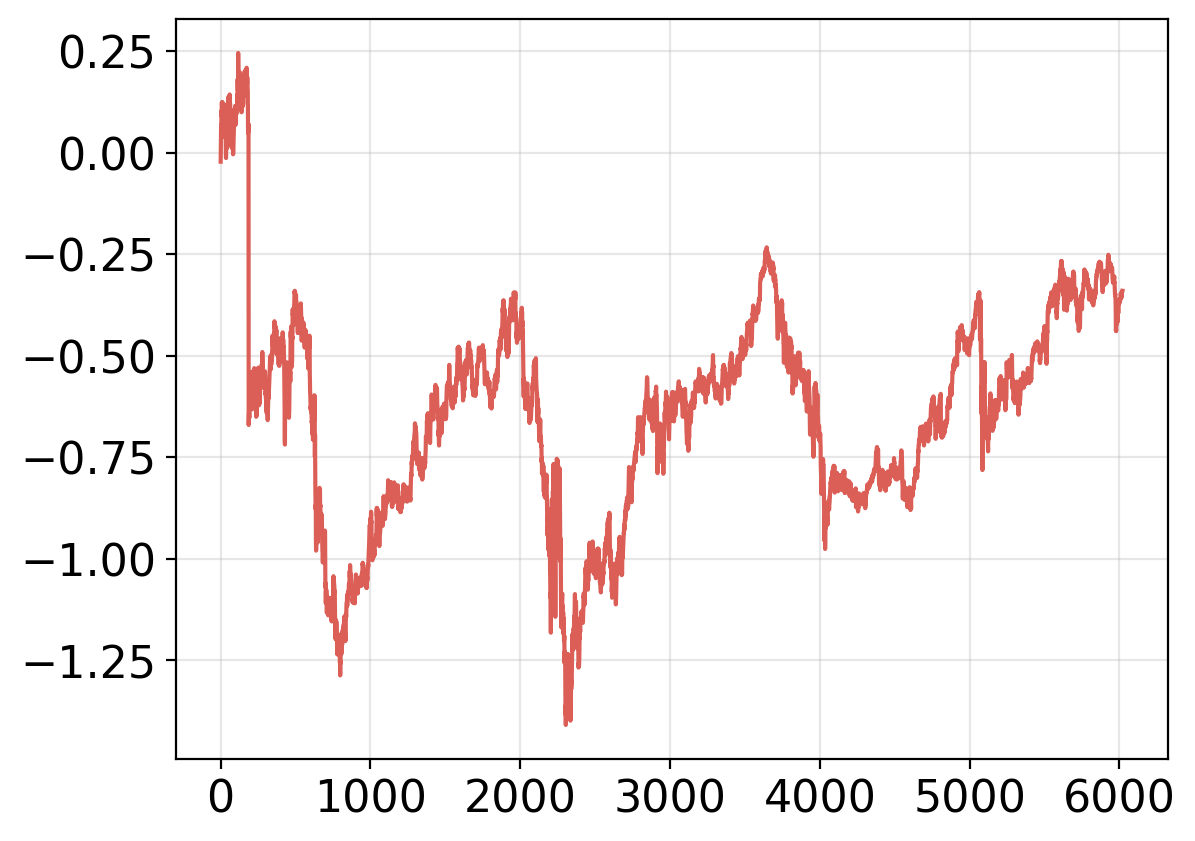

In [75]:
plt.plot(returns_bandit.cumsum())
plt.grid(alpha=0.3)

In [76]:
@partial(jax.vmap, in_axes=(None, None, 0), out_axes=1)
def returns_bandit(key, data, epsilon):
    _, n_arms = data.shape
    count_v = jnp.zeros(n_arms)
    value_v = jnp.zeros(n_arms)
    state = BanditState(count=count_v, value=value_v, key=key)
    
    _, returns_bandit = jax.lax.scan(partial(epsilon_step, epsilon=epsilon), state, data)
    return returns_bandit

In [77]:
n_simulations = 100
n_epsilon_values = 25
epsilon_values = jnp.linspace(1e-7, 1, n_epsilon_values)

In [84]:
%%time
keys = jax.random.split(key, n_simulations)
epsilon_greedy_returns = jax.vmap(returns_bandit, in_axes=(0, None, None))(keys, returns, epsilon_values)
epsilon_greedy_returns = np.array(epsilon_greedy_returns)
epsilon_greedy_cumsum = epsilon_greedy_returns.cumsum(axis=1)

CPU times: user 2.35 s, sys: 109 ms, total: 2.46 s
Wall time: 11.2 s


In [85]:
epsilon_greedy_final = epsilon_greedy_cumsum[:, -1, :]
epsilon_greedy_final = pd.DataFrame(
    epsilon_greedy_final, columns=epsilon_values
)

In [129]:
returns_mean = epsilon_greedy_returns[: 252:, :].mean(axis=1)
returns_std = epsilon_greedy_returns[: 252:, :].std(axis=1)
returns_sr = returns_mean / returns_std * jnp.sqrt(252)

returns_sr = pd.DataFrame(
    returns_sr,
    columns=epsilon_values
)

In [139]:
returns_sr_mean = returns_sr.mean()
returns_sr_mean.name = "mean_sr"

palette = sns.color_palette("viridis_r", n_epsilon_values)

colors = returns_sr_mean.reset_index().sort_values("mean_sr", ascending=False)
colors.index = sorted(colors.index)
colors = colors.reset_index()

colors["hue"] = colors.apply(lambda row: palette[int(row["level_0"])], axis=1)
colors = colors.sort_values("index")["hue"].to_list()

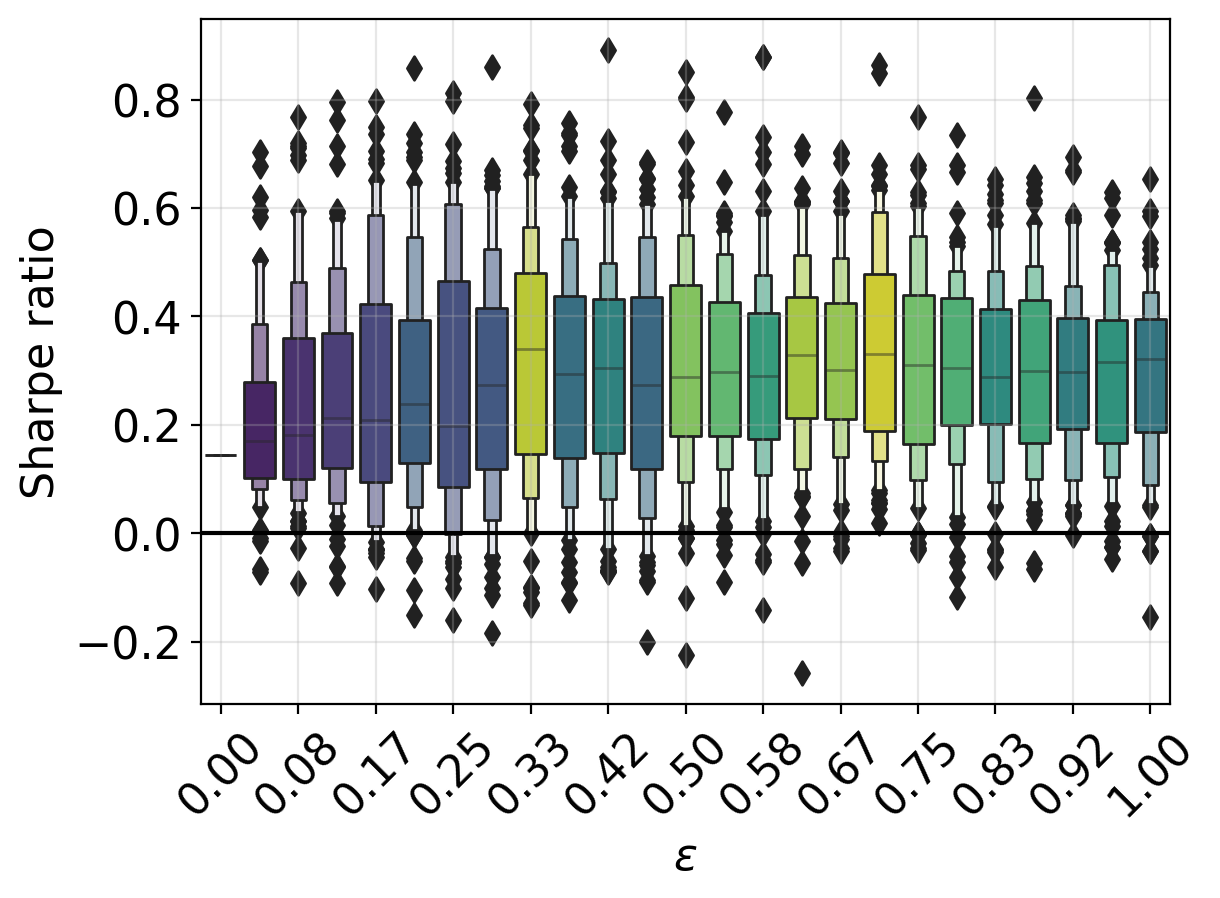

In [141]:
sns.boxenplot(
    x="variable",
    y="value",
    data=returns_sr.melt(),
    palette=colors,
    linewidth=1
)

plt.grid(alpha=0.3)
values, ticks = plt.xticks()
ticks = [format(float(t.get_text()), "0.2f") for t in ticks]
plt.xticks(values[::2], ticks[::2], rotation=45)
plt.xlabel("$\epsilon$")
plt.ylabel("Sharpe ratio")
plt.axhline(y=0, c="black")
plt.tight_layout()
plt.savefig("../figures/stationary-bandit-mean-sr.pdf")

In [109]:
median_value_final = epsilon_greedy_final.median(axis=0)
median_value_final.name = "median"

summary_final = epsilon_greedy_final.melt()
summary_final.tail()

,variable,value
2495,1.0,2.063518
2496,1.0,2.329459
2497,1.0,-0.038361
2498,1.0,2.575935
2499,1.0,3.469408


In [81]:
palette = sns.color_palette("viridis_r", n_epsilon_values)

colors = median_value_final.reset_index().sort_values("median", ascending=False)
colors.index = sorted(colors.index)
colors = colors.reset_index()

colors["hue"] = colors.apply(lambda row: palette[int(row["level_0"])], axis=1)
colors = colors.sort_values("index")["hue"].to_list()

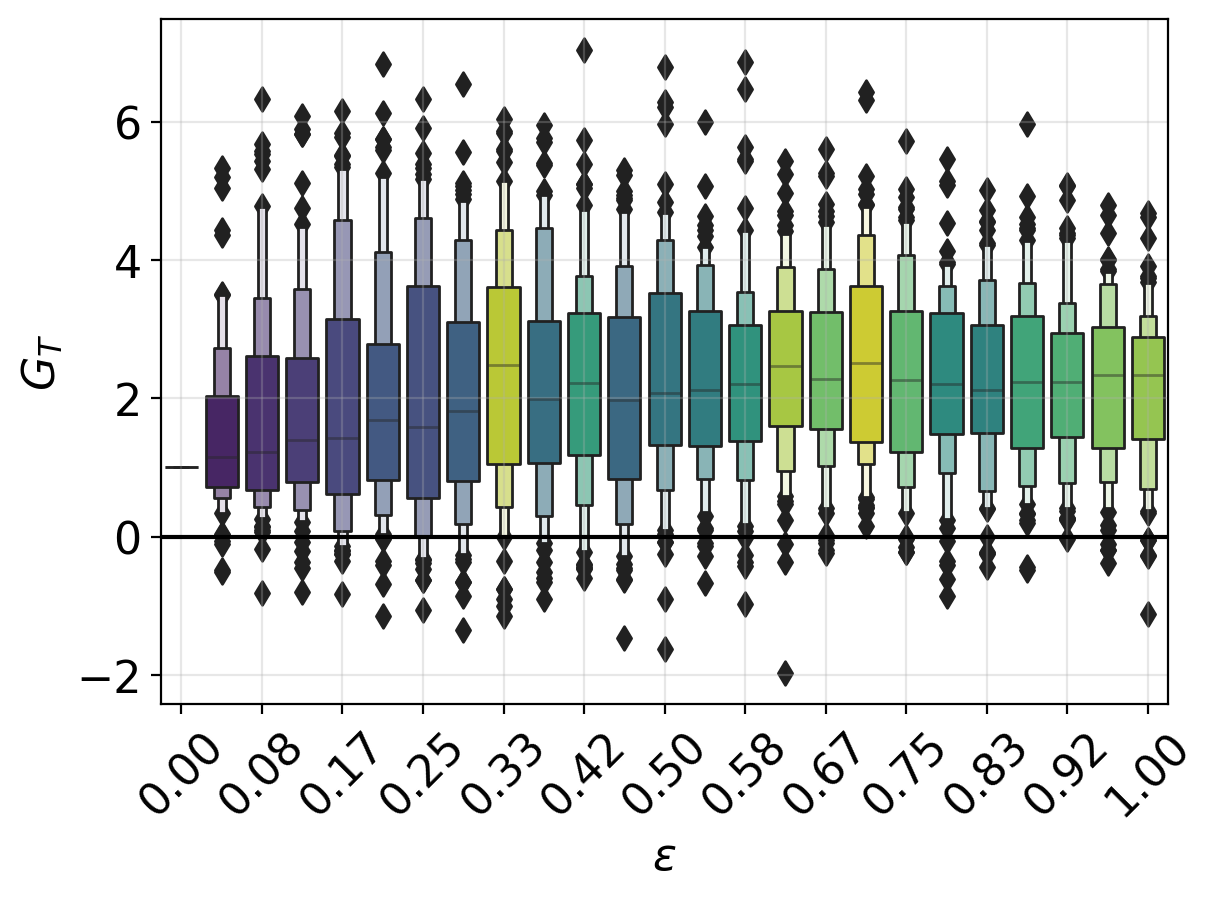

In [82]:
# NOTE: PRETTYFY with median_value_final

fig, ax = plt.subplots()
sns.boxenplot(
    y="value", x="variable", data=summary_final,
    palette=colors, linewidth=1, ax=ax,
)
plt.grid(alpha=0.3)
values, ticks = plt.xticks()
ticks = [format(float(t.get_text()), "0.2f") for t in ticks]
plt.xticks(values[::2], ticks[::2], rotation=45)
plt.xlabel("$\epsilon$")
plt.ylabel("$G_T$")
plt.tight_layout()
plt.axhline(y=0, c="black")
plt.savefig("../figures/rl-stationary-bandit-distribution.pdf")

0.50000006


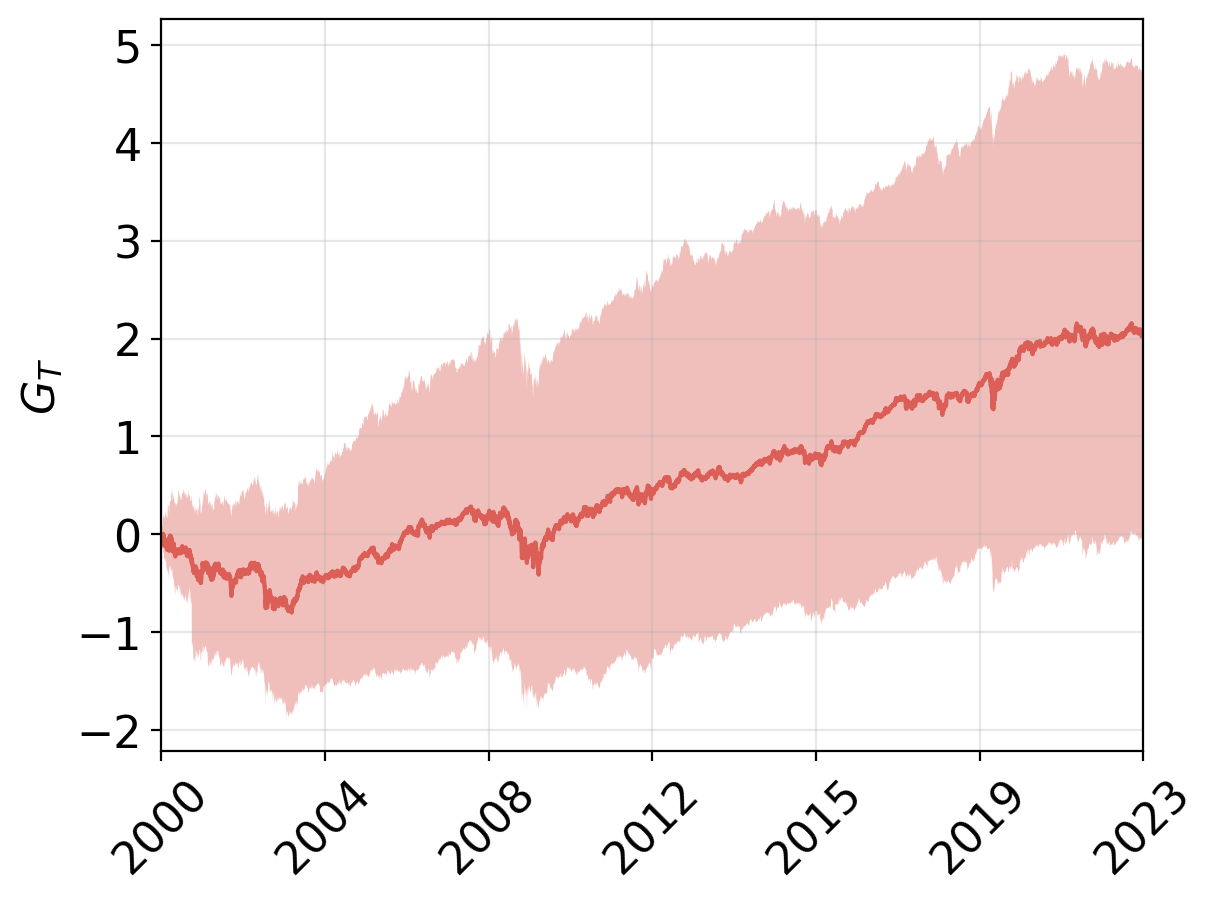

In [143]:
ix = 12
print(epsilon_values[ix])
plt.plot(
    np.percentile(epsilon_greedy_cumsum[:, :, ix], 50, axis=0)
)

lbound = np.percentile(epsilon_greedy_cumsum[:, :, ix], 5, axis=0)
ubound = np.percentile(epsilon_greedy_cumsum[:, :, ix], 95, axis=0)

plt.fill_between(timesteps, lbound, ubound, alpha=0.4)
plt.grid(alpha=0.3)
vals, _ = plt.xticks()
ticks = vals / 6000 * 23 + 2000
plt.xticks(vals, ticks.round().astype(int), rotation=45)
plt.ylabel("$G_T$")
plt.xlim(0, 6000)
plt.tight_layout()
plt.savefig("../figures/cumulative-reward-stationary-epsilon-greedy.pdf")

## Non-stationary version

In [144]:
def epsilon_ewm_step(state, returns, epsilon, alpha):
    key_choice, key_arm = jax.random.split(state.key)
    is_greedy = jax.random.bernoulli(key_choice, p=1 - epsilon)
    random_choice = jax.random.choice(key_arm, n_bandits)
    
    action = state.value.argmax() * is_greedy + random_choice * (1 - is_greedy) 
    reward = returns[action]

    new_value = state.value[action] + alpha * (reward - state.value[action])
    
    state = state.replace(
        value=state.value.at[action].set(new_value),
        key=jax.random.split(state.key)[1]
    )
    
    return state, (reward, action)

In [145]:
def epsilon_ewm_step(state, returns, epsilon, alpha):
    key_choice, key_arm = jax.random.split(state.key)
    is_greedy = jax.random.bernoulli(key_choice, p=1 - epsilon)
    random_choice = jax.random.choice(key_arm, n_bandits)
    
    action = state.value.argmax() * is_greedy + random_choice * (1 - is_greedy) 
    reward = returns[action]

    new_value = state.value[action] + alpha * (reward - state.value[action])
    
    state = state.replace(
        value=state.value.at[action].set(new_value),
        key=jax.random.split(state.key)[1]
    )
    
    return state, (reward, action, state.value)

In [146]:
def returns_bandit(key, data, alpha, epsilon):
    _, n_arms = data.shape
    count_v = jnp.zeros(n_arms)
    value_v = jnp.zeros(n_arms)
    state = BanditEWMState(value=value_v, key=key)
    
    _, returns_bandit = jax.lax.scan(partial(epsilon_ewm_step, epsilon=epsilon, alpha=alpha), state, data)
    return returns_bandit

In [147]:
@partial(jax.jit, static_argnames=("n_sims",))
def returns_bandit_sims(key, data, alpha, epsilon, n_sims):
    keys = jax.random.split(key, n_sims)
    vmap_returns = jax.vmap(returns_bandit, in_axes=(0, None, None, None))
    
    returns = vmap_returns(keys, data, alpha, epsilon)
    return returns

In [161]:
(sims, actions, value_hist) = returns_bandit_sims(key, returns, alpha=0.5, epsilon=0.82, n_sims=50)
final_reward = sims.sum(axis=1)
final_reward

Array([ 1.2471302 ,  1.4394329 ,  3.464039  ,  0.05896281,  0.74586695,
       -0.24327788,  1.7037487 ,  3.170216  ,  2.293634  ,  3.6927326 ,
       -0.04159296,  1.8803511 ,  1.7203112 ,  3.8087726 ,  2.8291113 ,
        1.0873693 ,  2.2205195 ,  2.821896  ,  2.2569275 ,  2.4851506 ,
        1.6014494 ,  1.6029892 ,  2.3323112 ,  3.6985877 ,  2.0882282 ,
        2.9144595 ,  3.8922386 ,  3.7096746 ,  0.9862282 ,  2.0782247 ,
        4.6009984 ,  4.1198506 ,  1.582198  ,  3.899541  ,  3.6726823 ,
        2.131386  ,  2.314149  ,  3.4770377 ,  3.329031  ,  0.78877044,
        2.5388288 ,  1.5977057 ,  0.63005185,  2.8156896 ,  2.2050471 ,
        0.7966364 ,  5.641661  ,  1.1034709 ,  2.208356  ,  0.4454403 ],      dtype=float32)

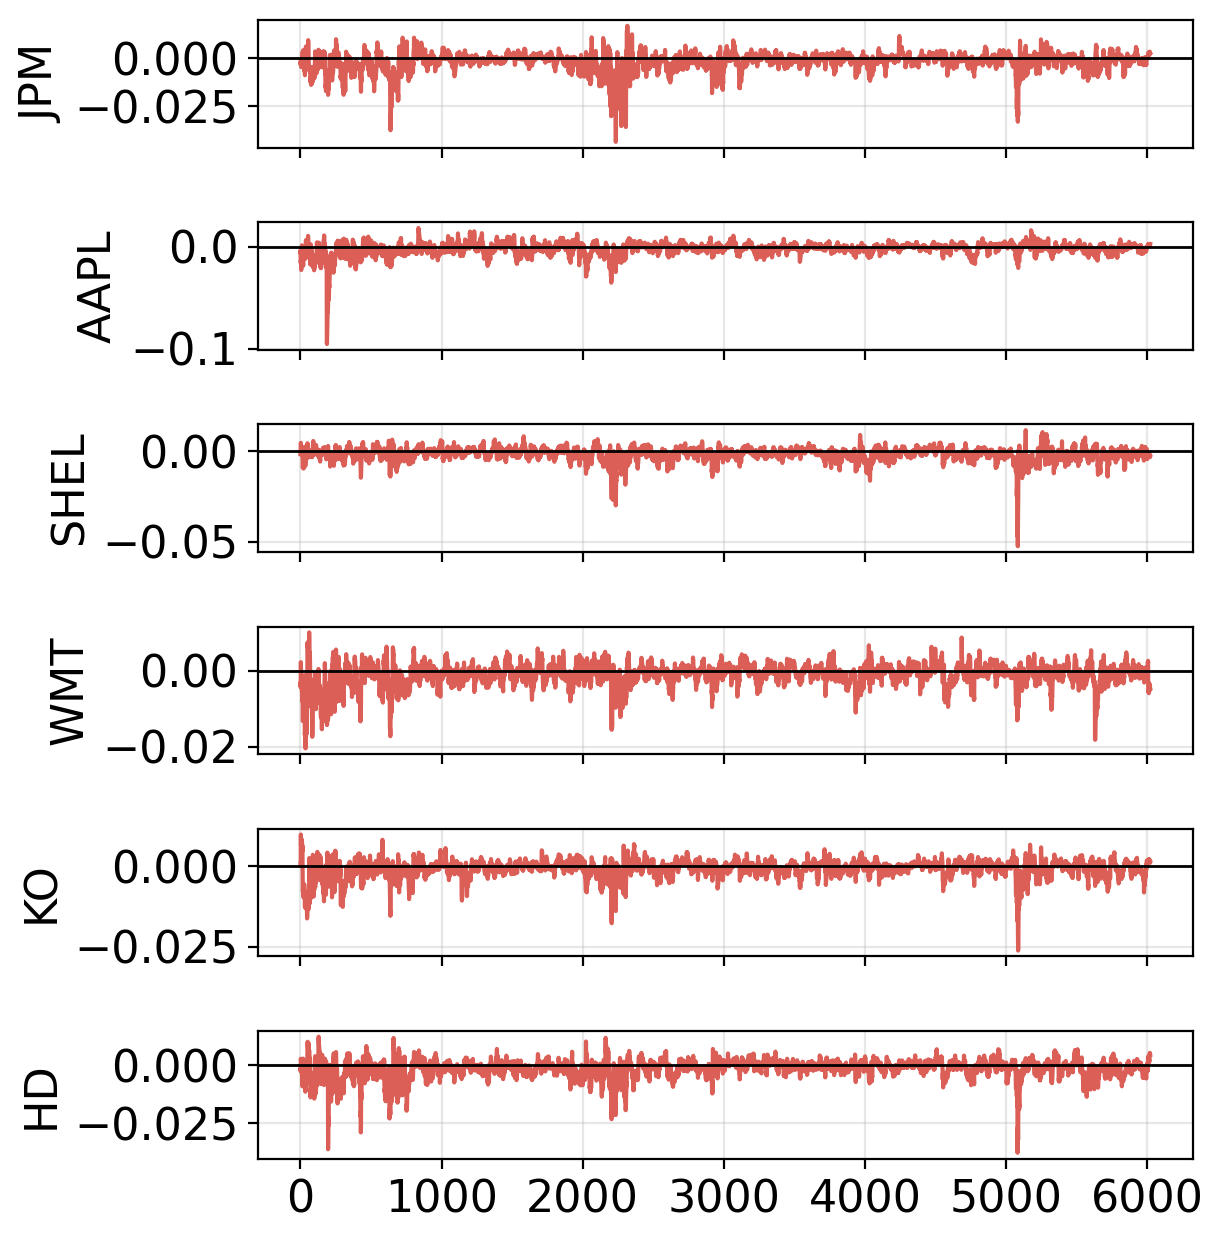

In [149]:
fig, ax = plt.subplots(len(assets), 1, figsize=(6.4, 6.5), sharex=True)
for i, axi in enumerate(ax):
    axi.plot(value_hist[..., i].mean(axis=0))
    axi.grid(alpha=0.3)
    axi.set_ylabel(assets[i])
    axi.axhline(y=0, c="black", linewidth=1)
plt.tight_layout()

In [150]:
np.bincount(np.percentile(actions, 50, axis=0).astype(int))

array([   0,  117, 3521, 2347,   36])

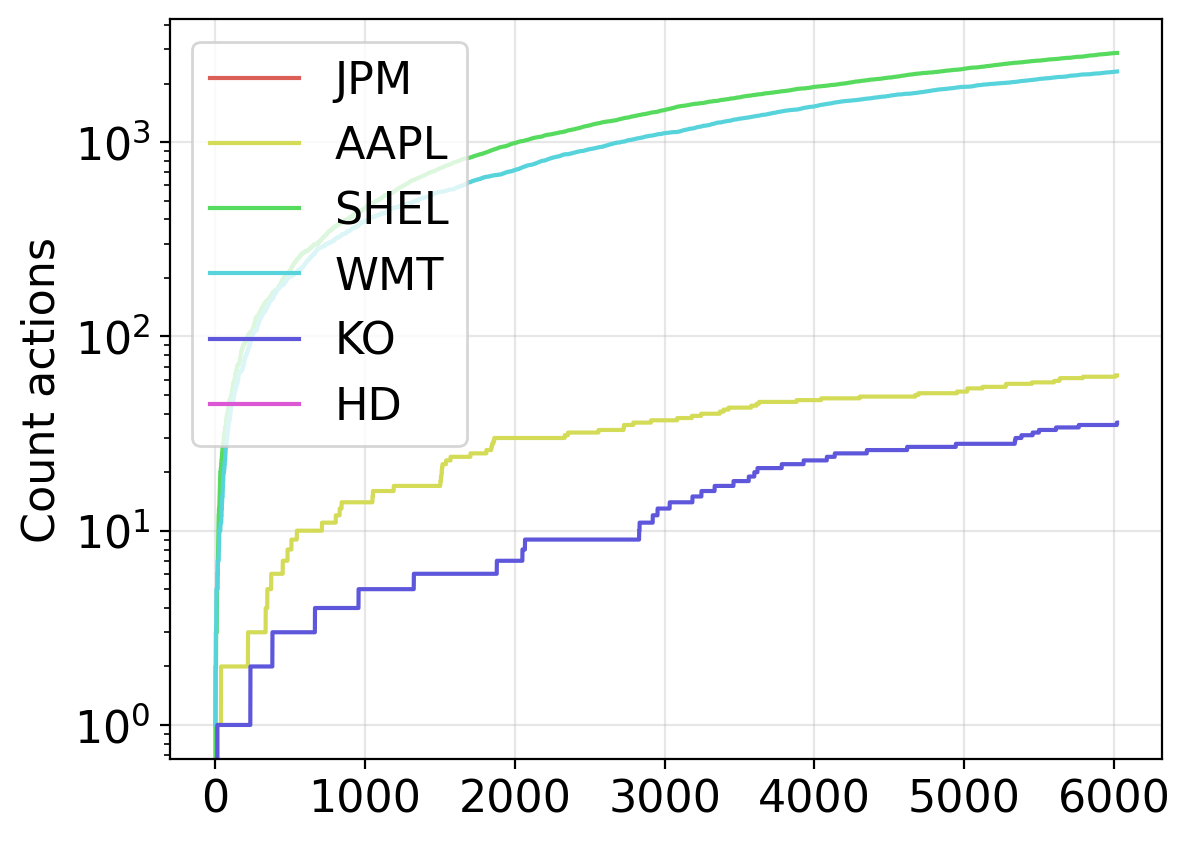

In [151]:
actions_sum = np.array(jax.nn.one_hot(jnp.percentile(actions, 50, axis=0), len(assets)))
plt.plot(actions_sum.cumsum(axis=0), label=assets)
plt.legend()
plt.ylabel("Count actions")
plt.yscale("log")
plt.grid(alpha=0.3)

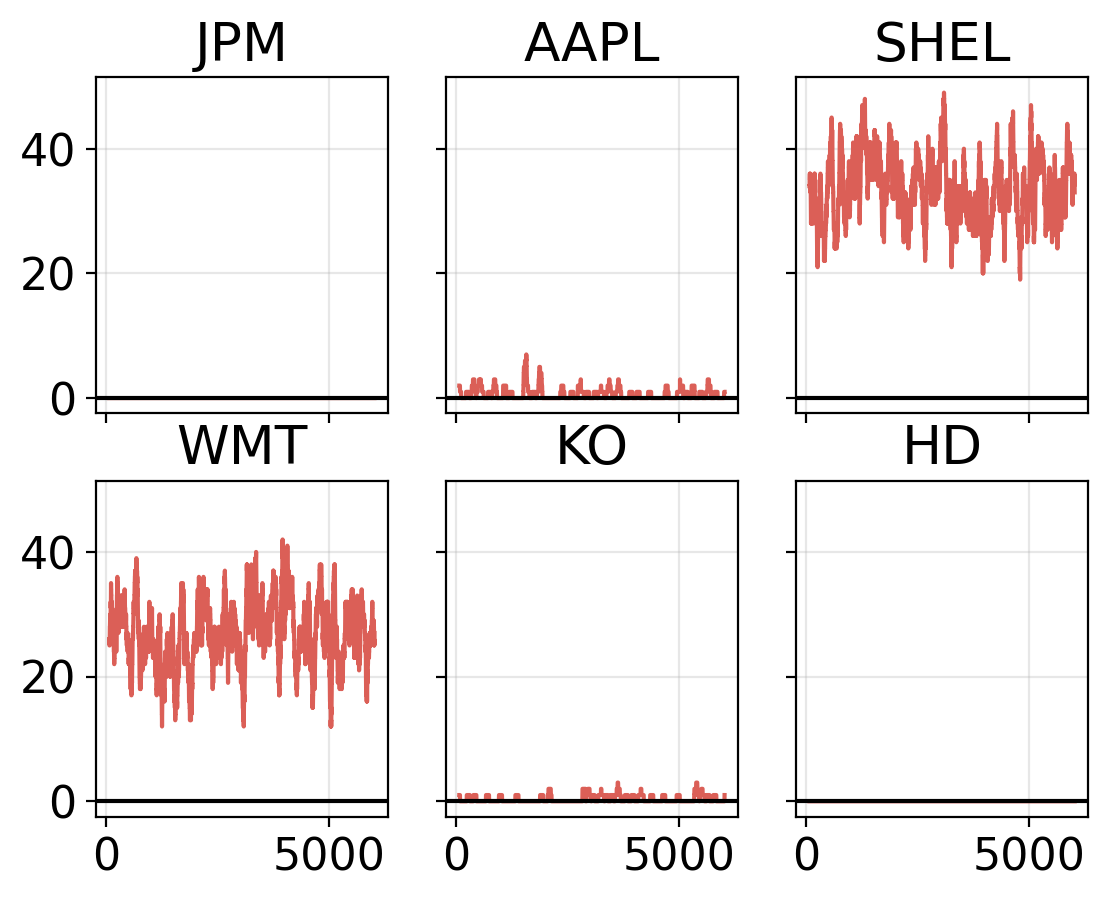

In [152]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
ax = ax.ravel()
v = pd.DataFrame(actions_sum).rolling(280 // 4).sum()
for i, axi in enumerate(ax):
    axi.set_title(assets[i])
    axi.plot(v[i])
    axi.axhline(y=0, c="black")
    axi.grid(alpha=0.3)

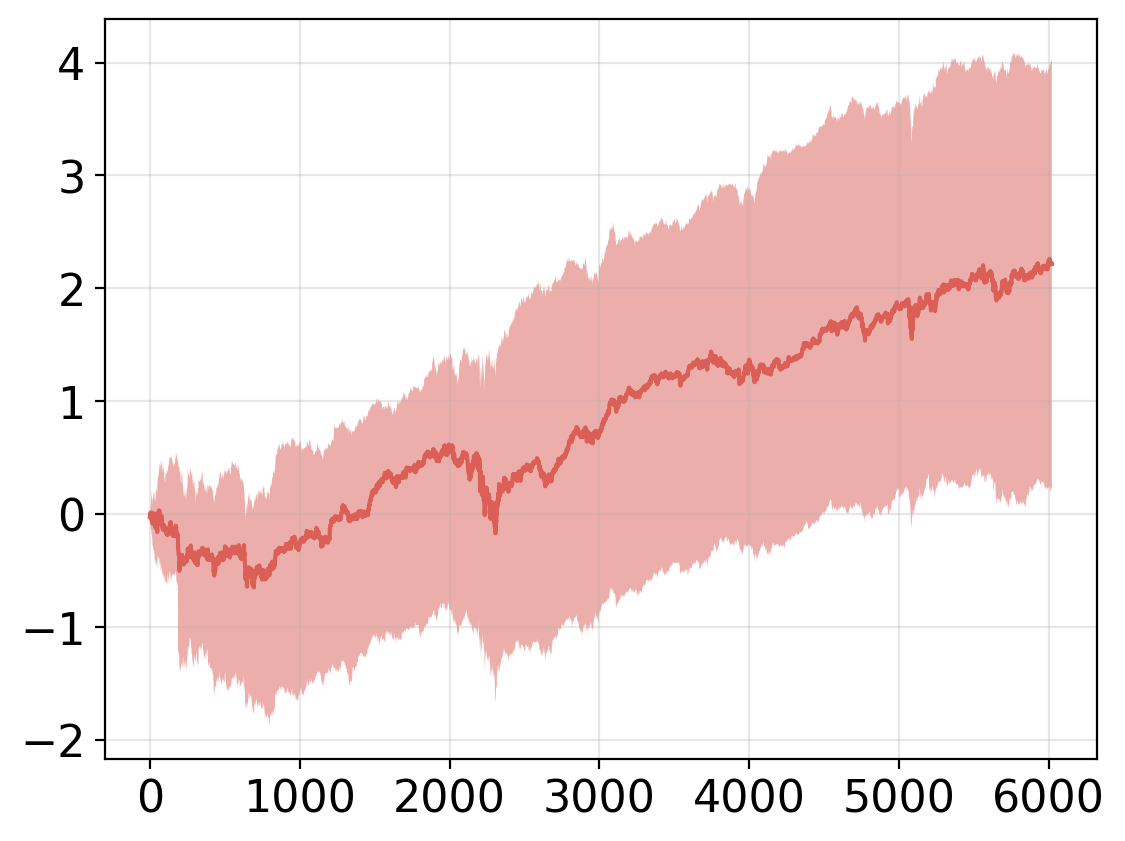

In [153]:
returns_cumsum = sims.cumsum(axis=1)
midval = jnp.percentile(returns_cumsum, q=50, axis=0)
lbound = jnp.percentile(returns_cumsum, q=5, axis=0)
ubound = jnp.percentile(returns_cumsum, q=95, axis=0)

plt.plot(midval)
plt.fill_between(timesteps, ubound, lbound, alpha=0.5)
plt.grid(alpha=0.3)

In [166]:
@partial(jax.vmap, in_axes=(None, None, 0, None, None))
@partial(jax.vmap, in_axes=(None, None, None, 0, None))
def xfinal_reward_bandit(key, data, alpha, epsilon, n_sims):
    (rewards, _, _) = returns_bandit_sims(key, data, alpha, epsilon, n_sims)
    sr_ann = rewards.mean(axis=1) / rewards.std(axis=1) * np.sqrt(252)
    return rewards.sum(axis=1), sr_ann

In [169]:
%%time
n_simulations = 50
alpha_values = jnp.linspace(0.01, 1, 15)
epsilon_values = jnp.linspace(0.01, 1, 25)

xfinal_reward, xsr = xfinal_reward_bandit(key, returns, alpha_values, epsilon_values, n_simulations)
xfinal_reward = pd.DataFrame(np.array(xfinal_reward).mean(axis=-1), index=alpha_values, columns=epsilon_values)

CPU times: user 71.3 ms, sys: 44.1 ms, total: 115 ms
Wall time: 57.2 s


In [180]:
returns_sr_mean

1.000000e-07    0.144096
4.166676e-02    0.212539
8.333343e-02    0.244259
1.250001e-01    0.254770
1.666668e-01    0.268986
2.083334e-01    0.275747
2.500001e-01    0.271874
2.916667e-01    0.272490
3.333334e-01    0.325207
3.750001e-01    0.292094
4.166667e-01    0.295436
4.583334e-01    0.276843
5.000001e-01    0.313853
5.416667e-01    0.304647
5.833334e-01    0.300689
6.250001e-01    0.323865
6.666667e-01    0.315392
7.083334e-01    0.347664
7.500000e-01    0.309288
7.916667e-01    0.303695
8.333334e-01    0.296548
8.750000e-01    0.303117
9.166667e-01    0.295382
9.583334e-01    0.299619
1.000000e+00    0.292991
Name: mean_sr, dtype: float32

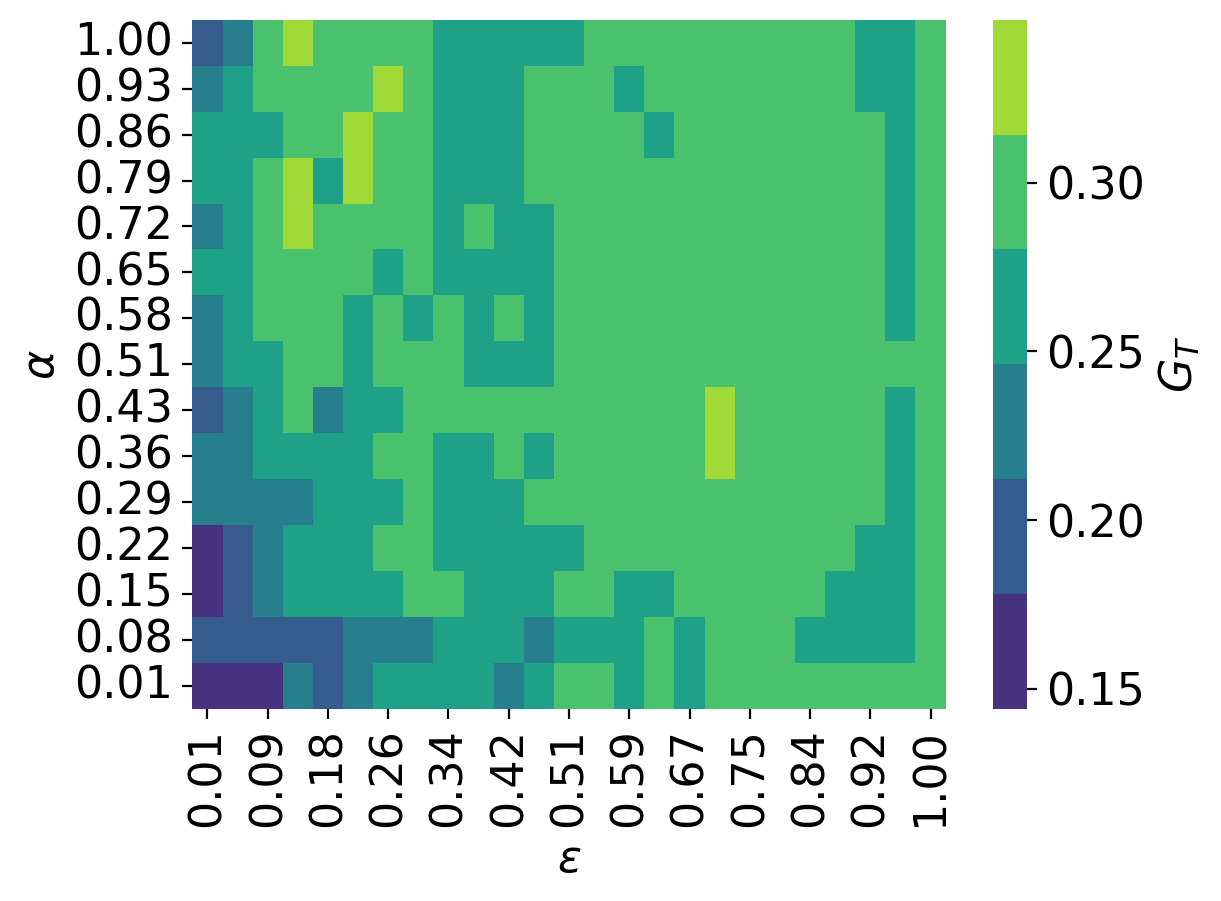

In [186]:
xsr_mean = pd.DataFrame(
    np.array(xsr.mean(axis=-1)),
    index=alpha_values, columns=epsilon_values
)

palette = sns.color_palette("viridis")

ax = sns.heatmap(
   xsr_mean,
    cmap=palette,
    cbar_kws={"label": "$G_T$"}
)
ax.set_yticklabels([format(float(v.get_text()), "0.2f") for v in ax.get_yticklabels()])
ax.set_xticklabels([format(float(v.get_text()), "0.2f") for v in ax.get_xticklabels()])
ax.invert_yaxis()

plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$\alpha$")
plt.tight_layout()
plt.savefig("../figures/non-stationary-alpha-epsilon-grid-sr.pdf", dpi=300);

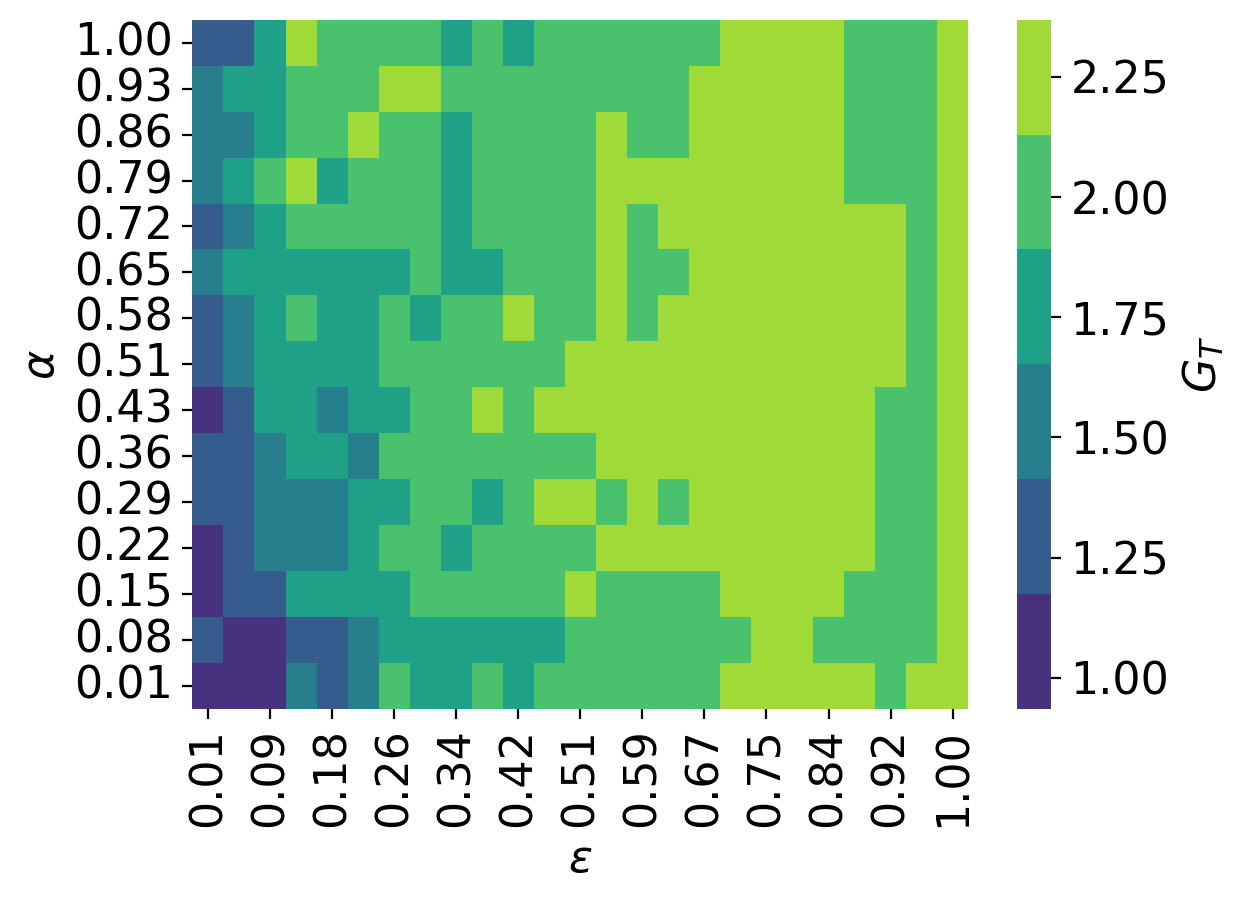

In [187]:
palette = sns.color_palette("viridis")

ax = sns.heatmap(
   xfinal_reward,
    cmap=palette,
    cbar_kws={"label": "$G_T$"}
)
ax.set_yticklabels([format(float(v.get_text()), "0.2f") for v in ax.get_yticklabels()])
ax.set_xticklabels([format(float(v.get_text()), "0.2f") for v in ax.get_xticklabels()])
ax.invert_yaxis()

plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$\alpha$")
plt.tight_layout()
plt.savefig("../figures/non-stationary-alpha-epsilon-grid.pdf", dpi=300);

## Tabular Contextual bandits

In [38]:
context = (returns > 0) * 1
context.shape

(6021, 6)

In [39]:
def contextual_epsilon_ewm_step(state, xs, epsilon, alpha):
    returns, context = xs
    context = tuple(context)
    key_choice, key_arm = jax.random.split(state.key)
    is_greedy = jax.random.bernoulli(key_choice, p=1 - epsilon)
    random_choice = jax.random.choice(key_arm, n_bandits)
    
    action = state.value[context].argmax() * is_greedy + random_choice * (1 - is_greedy) 
    reward = returns[action]

    update_ix = tuple((*context, action))
    new_value = state.value[update_ix] + alpha * (reward - state.value[update_ix])
    
    state = state.replace(
        value=state.value.at[update_ix].set(new_value),
        key=jax.random.split(state.key)[1]
    )
    
    return state, (reward, action)

In [40]:
def returns_bandit(key, rewards, context, alpha, epsilon):
    _, n_arms = data.shape
    shape = (*(2,) * n_arms, n_arms)
    value_v = jnp.zeros(shape)
    state = BanditEWMState(value=value_v, key=key)
    
    xs = (rewards, context)
    state_final, (returns_bandit, actions) = jax.lax.scan(partial(contextual_epsilon_ewm_step, epsilon=epsilon, alpha=alpha), state, xs)
    return returns_bandit, actions

In [65]:
res, actions = returns_bandit(key, returns[1:], context[:-1], alpha=0.5, epsilon=0.75)
actions_ohe = jax.nn.one_hot(actions, len(assets))

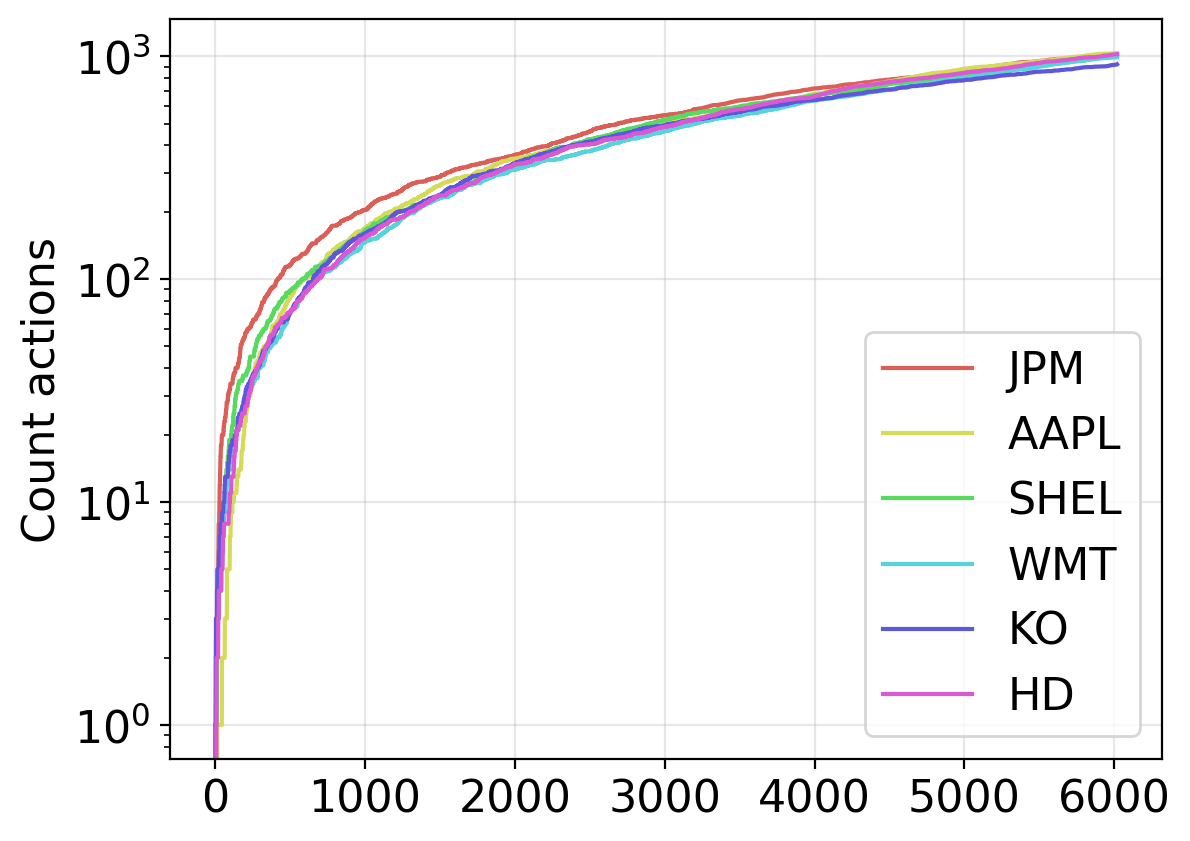

In [66]:
plt.plot(actions_ohe.cumsum(axis=0), label=assets)
plt.legend()
plt.ylabel("Count actions")
plt.yscale("log")
plt.grid(alpha=0.3)

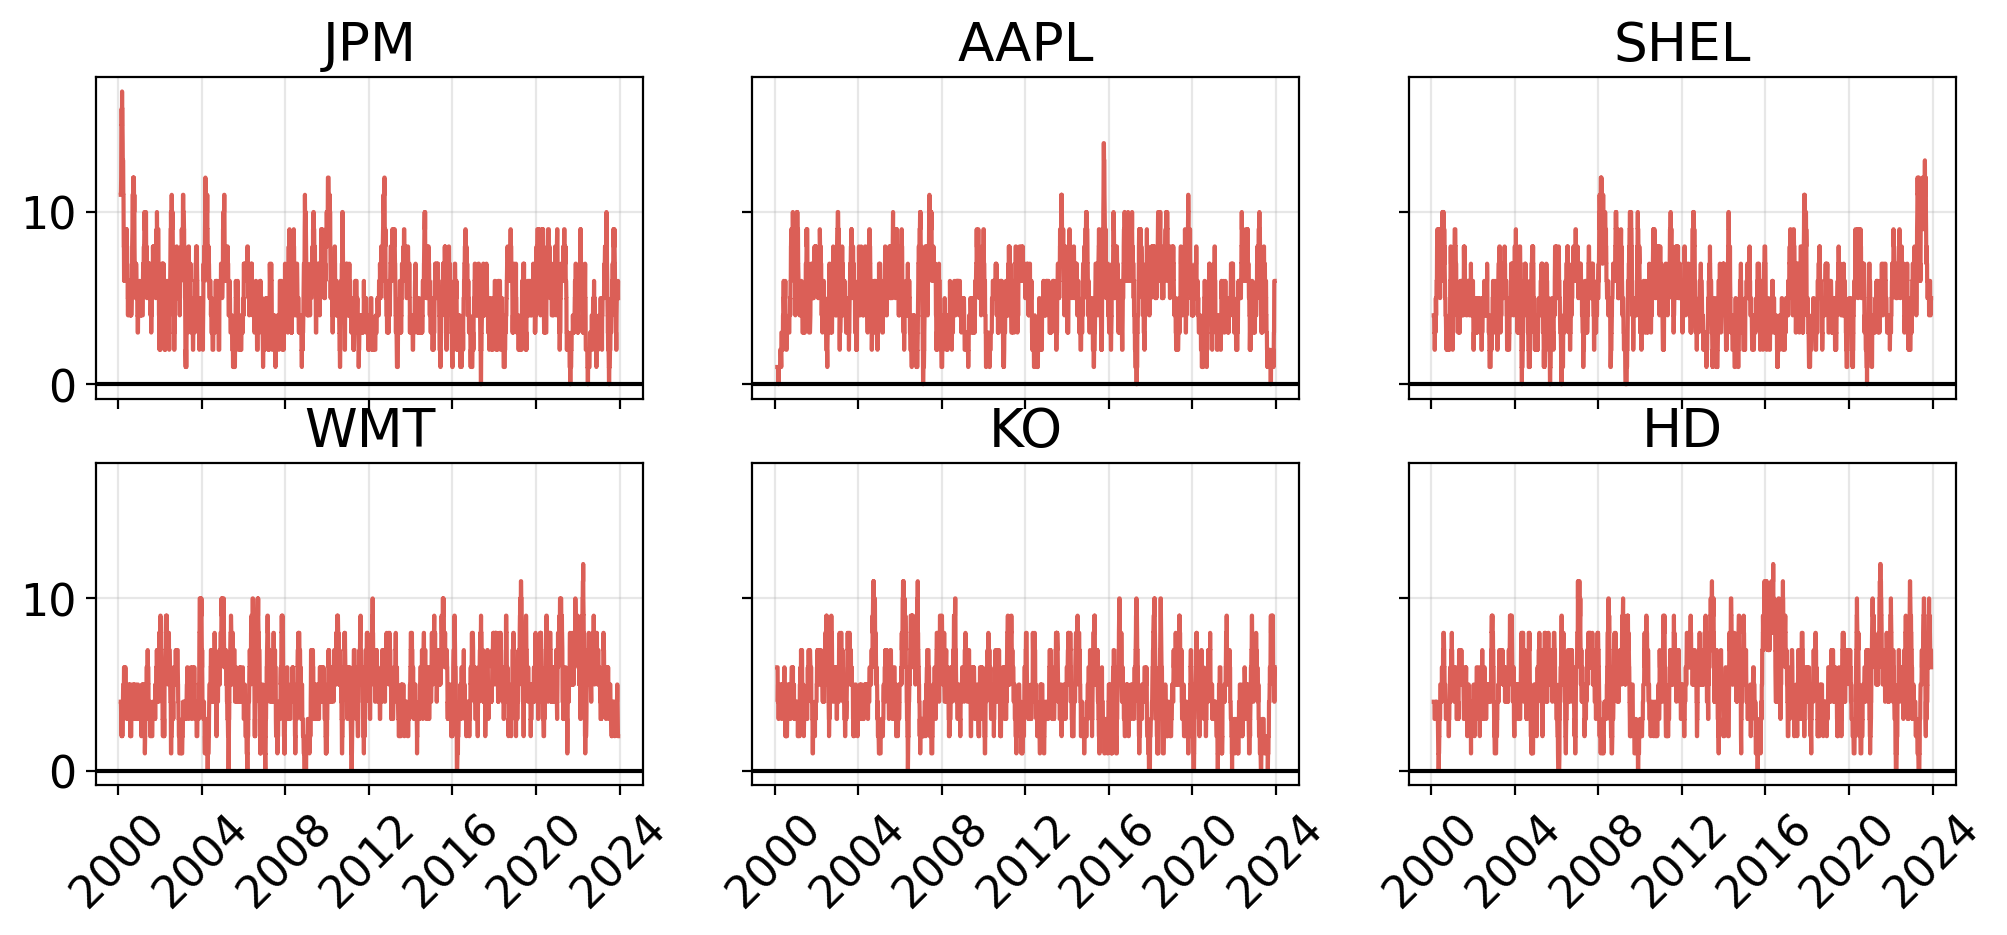

In [67]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 4.6))
ax = ax.ravel()
v = pd.DataFrame(actions_ohe, index=datasets.index[2:]).rolling(30).sum()
for i, axi in enumerate(ax):
    axi.set_title(assets[i])
    axi.plot(v[i])
    axi.axhline(y=0, c="black")
    axi.grid(alpha=0.3)
    plt.sca(axi)
    plt.xticks(rotation=45)

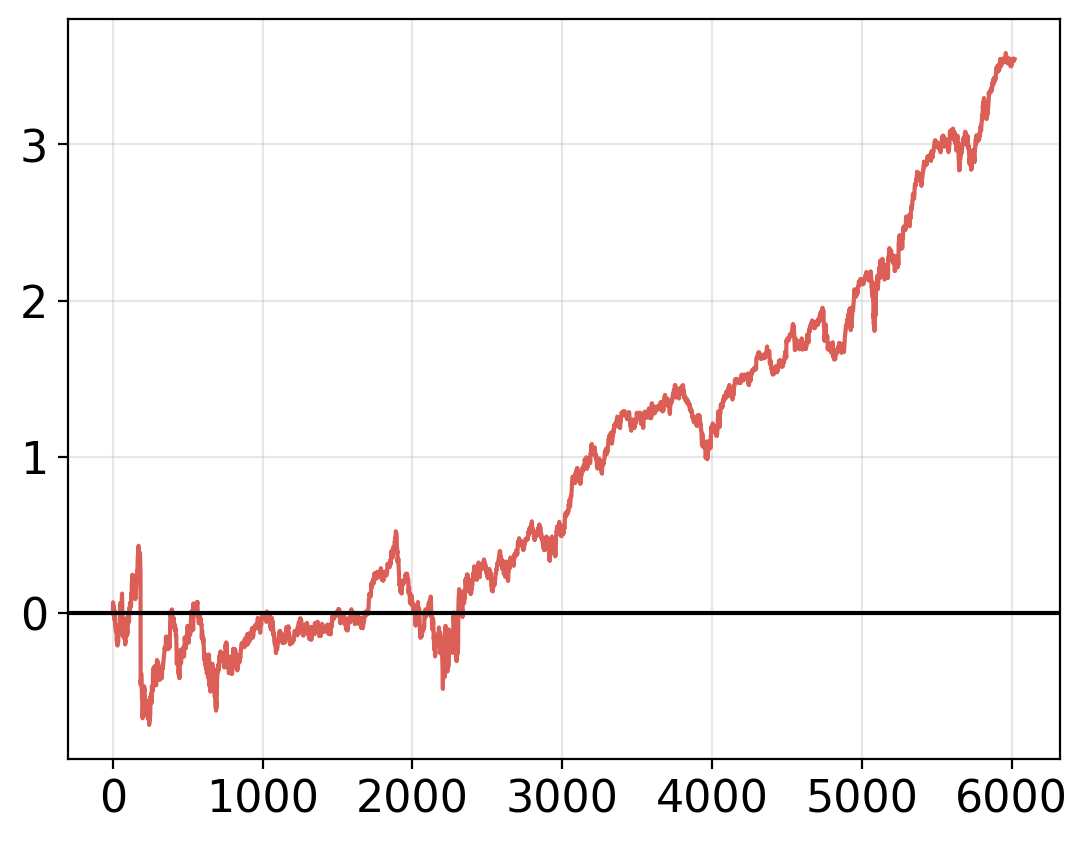

In [68]:
plt.plot(res.cumsum())
plt.grid(alpha=0.3)
plt.axhline(y=0, c="black")

In [69]:
sharpe_ratio = res.mean() / res.std() * np.sqrt(252)
sharpe_ratio

Array(0.4276216, dtype=float32)